In [7]:
# AA
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # or "true"

import requests
from zipfile import ZipFile

GLOVE_FILE_NAME = 'glove.6B.100d.txt'
GLOVE_ZIP_URL = 'http://nlp.stanford.edu/data/glove.6B.zip' # Example for glove.6B
GLOVE_LOCAL_ZIP_PATH = '/kaggle/working/glove.6B.zip'
GLOVE_EXTRACT_DIR = '/kaggle/working/glove6b/'
GLOVE_FILE = os.path.join(GLOVE_EXTRACT_DIR, GLOVE_FILE_NAME)

if not os.path.exists(GLOVE_FILE):
    print("GloVe file not found, attempting to download and extract...")
    if not os.path.exists(GLOVE_EXTRACT_DIR):
        os.makedirs(GLOVE_EXTRACT_DIR)
    try:
        # Download
        response = requests.get(GLOVE_ZIP_URL, stream=True)
        with open(GLOVE_LOCAL_ZIP_PATH, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Downloaded GloVe zip.")
        # Extract
        with ZipFile(GLOVE_LOCAL_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(GLOVE_EXTRACT_DIR)
        print(f"Extracted GloVe files to {GLOVE_EXTRACT_DIR}")
        if not os.path.exists(GLOVE_FILE):
            print(f"Error: {GLOVE_FILE_NAME} not found in extracted files.")
            glove_embeddings_index = None # Ensure fallback
        else:
            print(f"GloVe file ready at: {GLOVE_FILE}")
    except Exception as e:
        print(f"Error downloading/extracting GloVe: {e}")
        glove_embeddings_index = None # Ensure fallback
else:
    print(f"Using existing GloVe file: {GLOVE_FILE}")

GloVe file not found, attempting to download and extract...
Downloaded GloVe zip.
Extracted GloVe files to /kaggle/working/glove6b/
GloVe file ready at: /kaggle/working/glove6b/glove.6B.100d.txt


In [8]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# For transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch # Ensure PyTorch is installed if using Hugging Face Transformers with PyTorch backend

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
# --- 1. Dataset Selection & Loading ---
print("--- Part 1: Dataset Selection & Loading ---")

# Load the dataset
try:
    df = pd.read_csv('/kaggle/input/bbc-dataset/bbc-text.csv')
except FileNotFoundError:
    print("Error: bbc-text.csv not found. Please make sure it's in the same directory or provide the correct path.")
    exit()

print("\nDataset Head:")
print(df.head())

# Display basic dataset information
print(f"\nTotal number of records: {len(df)}")

print("\nNumber of samples in each class:")
print(df['category'].value_counts())

# Combine all text for word analysis
all_text = ' '.join(df['text'])
words = word_tokenize(all_text.lower()) # Simple tokenization for word count
print(f"\nTotal number of words (approximate, before cleaning): {len(words)}")

# Top 20 most frequent words (before detailed preprocessing)
word_counts = Counter(words)
# Filter out some common punctuation and very short words for a more meaningful top 20 list at this stage
# This is a quick filter; proper preprocessing will handle this better.
filtered_word_counts = Counter({word: count for word, count in word_counts.items() if len(word) > 2 and word.isalpha()})
top_20_words = filtered_word_counts.most_common(20)

print("\nTop 20 most frequent words (approximate, before cleaning) and their frequencies:")
for word, freq in top_20_words:
    print(f"{word}: {freq}")

# Store original texts and labels for later use
X_original = df['text']
y_original = df['category']

--- Part 1: Dataset Selection & Loading ---

Dataset Head:
        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...

Total number of records: 2225

Number of samples in each class:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Total number of words (approximate, before cleaning): 917506

Top 20 most frequent words (approximate, before cleaning) and their frequencies:
the: 52604
and: 18572
for: 8918
that: 8255
said: 7254
was: 6028
with: 5344
has: 4956
have: 4750
will: 4473
but: 4421
are: 4400
not: 3642
from: 3534
they: 3085
his: 3024
this: 2846
whic

In [10]:
# --- 2. Text Preprocessing ---
print("\n\n--- Part 2: Text Preprocessing ---")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(processed_tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)

print("\nSample of cleaned text:")
print(df[['text', 'cleaned_text']].head())

# Recalculate total words and top 20 frequent words on cleaned text
all_cleaned_text = ' '.join(df['cleaned_text'])
cleaned_words = all_cleaned_text.split() # Already tokenized and joined
print(f"\nTotal number of words (after cleaning): {len(cleaned_words)}")

cleaned_word_counts = Counter(cleaned_words)
top_20_cleaned_words = cleaned_word_counts.most_common(20)

print("\nTop 20 most frequent words (after cleaning) and their frequencies:")
for word, freq in top_20_cleaned_words:
    print(f"{word}: {freq}")

X = df['cleaned_text']
y = df['category']



--- Part 2: Text Preprocessing ---

Sample of cleaned text:
                                                text  \
0  tv future in the hands of viewers with home th...   
1  worldcom boss  left books alone  former worldc...   
2  tigers wary of farrell  gamble  leicester say ...   
3  yeading face newcastle in fa cup premiership s...   
4  ocean s twelve raids box office ocean s twelve...   

                                        cleaned_text  
0  tv future hand viewer home theatre system plas...  
1  worldcom bos left book alone former worldcom b...  
2  tiger wary farrell gamble leicester say rushed...  
3  yeading face newcastle fa cup premiership side...  
4  ocean twelve raid box office ocean twelve crim...  

Total number of words (after cleaning): 478057

Top 20 most frequent words (after cleaning) and their frequencies:
said: 7254
mr: 3045
year: 2860
would: 2577
also: 2156
people: 2044
new: 1970
u: 1930
one: 1809
could: 1511
game: 1474
time: 1450
last: 1381
first: 1283
say

In [11]:
# --- 3. Train-Test Split ---
print("\n\n--- Part 3: Train-Test Split ---")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"Labels encoded. Classes: {label_encoder.classes_}, Encoded: {np.unique(y_encoded)}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training labels distribution:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Test labels distribution:\n{pd.Series(y_test).value_counts(normalize=True)}")



--- Part 3: Train-Test Split ---
Labels encoded. Classes: ['business' 'entertainment' 'politics' 'sport' 'tech'], Encoded: [0 1 2 3 4]

Training set size: 1780
Test set size: 445
Training labels distribution:
3    0.229775
0    0.229213
2    0.187079
4    0.180337
1    0.173596
Name: proportion, dtype: float64
Test labels distribution:
0    0.229213
3    0.229213
2    0.188764
4    0.179775
1    0.173034
Name: proportion, dtype: float64


In [12]:
# --- 4. Feature Representation ---
print("\n\n--- Part 4: Feature Representation ---")

# a. Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000) # Limit features for efficiency
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
print(f"\nBoW features shape (train): {X_train_bow.shape}")

# b. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"TF-IDF features shape (train): {X_train_tfidf.shape}")

# c. Word Embeddings (GloVe - Average)
# For classical ML, we'll average word embeddings for each document.
# Download GloVe embeddings (e.g., glove.6B.100d.txt) from https://nlp.stanford.edu/projects/glove/
# and place it in your working directory or provide the path.

GLOVE_FILE = '/kaggle/working/glove6b/glove.6B.100d.txt' # Update this path if needed
embedding_dim_glove = 100

def load_glove_embeddings(file_path):
    embeddings_index = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    except FileNotFoundError:
        print(f"Error: GloVe file '{file_path}' not found. Please download and place it correctly.")
        print("Skipping GloVe feature representation for classical models.")
        return None
    return embeddings_index

glove_embeddings_index = load_glove_embeddings(GLOVE_FILE)

def get_average_word_embeddings(texts, embeddings_index, embedding_dim):
    if embeddings_index is None:
        return np.zeros((len(texts), embedding_dim)) # Return zeros if GloVe not loaded

    document_embeddings = np.zeros((len(texts), embedding_dim))
    for i, text in enumerate(texts):
        words = text.split()
        word_vectors = [embeddings_index[word] for word in words if word in embeddings_index]
        if len(word_vectors) > 0:
            document_embeddings[i] = np.mean(word_vectors, axis=0)
    return document_embeddings

if glove_embeddings_index:
    X_train_glove_avg = get_average_word_embeddings(X_train, glove_embeddings_index, embedding_dim_glove)
    X_test_glove_avg = get_average_word_embeddings(X_test, glove_embeddings_index, embedding_dim_glove)
    print(f"Average GloVe features shape (train): {X_train_glove_avg.shape}")
else:
    # Create dummy arrays if GloVe failed to load, so the rest of the script doesn't break.
    # Models using GloVe might not perform well or might be skipped.
    X_train_glove_avg = np.zeros((len(X_train), embedding_dim_glove))
    X_test_glove_avg = np.zeros((len(X_test), embedding_dim_glove))
    print("GloVe embeddings could not be loaded. Using zero vectors for GloVe features.")


# We will store these for classical ML. Deep learning models will build their own or use embeddings differently.
feature_sets = {}
if 'X_train_bow' in locals():
    feature_sets['BoW'] = (X_train_bow, X_test_bow)
if 'X_train_tfidf' in locals():
    feature_sets['TF-IDF'] = (X_train_tfidf, X_test_tfidf)
if 'X_train_glove_avg' in locals() and glove_embeddings_index: # Only add if GloVe was successful
    feature_sets['GloVe_Avg'] = (X_train_glove_avg, X_test_glove_avg)



--- Part 4: Feature Representation ---

BoW features shape (train): (1780, 5000)
TF-IDF features shape (train): (1780, 5000)
Average GloVe features shape (train): (1780, 100)


In [13]:
# --- 5. Classical Machine Learning Models ---
print("\n\n--- Part 5: Classical Machine Learning Models ---")

classifiers = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=SEED, max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(probability=True, random_state=SEED), # probability=True for ROC-AUC
    "Random Forest": RandomForestClassifier(random_state=SEED, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_jobs=-1)
}

# Store results
classical_ml_results = []

# For Naive Bayes, it requires non-negative features. GloVe_Avg can have negative values.
# We will skip Naive Bayes for GloVe_Avg or use a scaler if desired (for simplicity, skipping here).

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']

for feature_name, (X_train_fs, _) in feature_sets.items(): # We only need X_train_fs for CV
    print(f"\n--- Evaluating models with {feature_name} features ---")
    for clf_name, classifier in classifiers.items():
        if feature_name == "GloVe_Avg" and clf_name == "Naive Bayes":
            print(f"Skipping Naive Bayes for {feature_name} as it may contain negative values.")
            continue
        if feature_name == "GloVe_Avg" and clf_name == "KNN" and np.all(X_train_fs == 0):
            print(f"Skipping KNN for {feature_name} as GloVe features are all zeros (load failed).")
            continue

        print(f"Cross-validating {clf_name}...")
        try:
            # Note: For BoW and TF-IDF, X_train_fs is already transformed.
            # For GloVe_Avg, it's a dense array.
            cv_results = cross_validate(classifier, X_train_fs, y_train, cv=5, scoring=scoring_metrics, n_jobs=-1)

            result_entry = {
                "Model": clf_name,
                "Feature Set": feature_name,
                "Accuracy (CV)": cv_results['test_accuracy'].mean(),
                "Precision (CV)": cv_results['test_precision_macro'].mean(),
                "Recall (CV)": cv_results['test_recall_macro'].mean(),
                "F1 Score (CV)": cv_results['test_f1_macro'].mean(),
                "ROC-AUC (CV)": cv_results['test_roc_auc_ovr'].mean() if 'test_roc_auc_ovr' in cv_results else np.nan
            }
            classical_ml_results.append(result_entry)
            print(f"{clf_name} with {feature_name} - Avg F1 (CV): {result_entry['F1 Score (CV)']:.4f}")
        except Exception as e:
            print(f"Error during cross-validation for {clf_name} with {feature_name}: {e}")
            result_entry = {
                "Model": clf_name,
                "Feature Set": feature_name,
                "Accuracy (CV)": np.nan, "Precision (CV)": np.nan, "Recall (CV)": np.nan,
                "F1 Score (CV)": np.nan, "ROC-AUC (CV)": np.nan
            }
            classical_ml_results.append(result_entry)


classical_ml_results_df = pd.DataFrame(classical_ml_results)
print("\n--- Classical ML Cross-Validation Results ---")
print(classical_ml_results_df)



--- Part 5: Classical Machine Learning Models ---

--- Evaluating models with BoW features ---
Cross-validating Logistic Regression...
Logistic Regression with BoW - Avg F1 (CV): 0.9696
Cross-validating Naive Bayes...
Naive Bayes with BoW - Avg F1 (CV): 0.9698
Cross-validating SVM...
SVM with BoW - Avg F1 (CV): 0.9550
Cross-validating Random Forest...
Random Forest with BoW - Avg F1 (CV): 0.9548
Cross-validating KNN...
KNN with BoW - Avg F1 (CV): 0.6604

--- Evaluating models with TF-IDF features ---
Cross-validating Logistic Regression...
Logistic Regression with TF-IDF - Avg F1 (CV): 0.9703
Cross-validating Naive Bayes...
Naive Bayes with TF-IDF - Avg F1 (CV): 0.9682
Cross-validating SVM...
SVM with TF-IDF - Avg F1 (CV): 0.9733
Cross-validating Random Forest...
Random Forest with TF-IDF - Avg F1 (CV): 0.9559
Cross-validating KNN...
KNN with TF-IDF - Avg F1 (CV): 0.9379

--- Evaluating models with GloVe_Avg features ---
Cross-validating Logistic Regression...
Logistic Regression wit

In [14]:
# --- 6. Deep Learning Models ---
print("\n\n--- Part 6: Deep Learning Models ---")

# Prepare data for Keras: Tokenize and Pad sequences
MAX_WORDS = 10000  # Max words to consider in the vocabulary
MAX_SEQUENCE_LENGTH = 200 # Max length of sequences

keras_tokenizer = KerasTokenizer(num_words=MAX_WORDS, oov_token="<unk>")
keras_tokenizer.fit_on_texts(X_train)

X_train_seq = keras_tokenizer.texts_to_sequences(X_train)
X_test_seq = keras_tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# One-hot encode labels for Keras
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Padded training sequences shape: {X_train_pad.shape}")
print(f"Padded test sequences shape: {X_test_pad.shape}")
print(f"One-hot encoded training labels shape: {y_train_cat.shape}")

# Create embedding matrix using GloVe (if loaded)
embedding_dim_dl = 100 # Should match the GloVe dimension used
word_index = keras_tokenizer.word_index
num_keras_tokens = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_keras_tokens, embedding_dim_dl))

if glove_embeddings_index:
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in embedding index will be all-zeros.
    print("GloVe embedding matrix created.")
    use_pretrained_embeddings = True
else:
    print("GloVe embeddings not loaded. DL models will use trainable embeddings.")
    use_pretrained_embeddings = False


# Common training parameters
EPOCHS = 10 # Reduce for faster run, increase for better performance (e.g., 10-20)
BATCH_SIZE = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

dl_models_results = []

# Function to build, train, and evaluate DL model
def train_and_evaluate_dl_model(model_builder_fn, model_name):
    print(f"\n--- Training {model_name} ---")
    model = model_builder_fn()
    model.summary()
    history = model.fit(
        X_train_pad, y_train_cat,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1, # Use a small portion of training data for validation during training
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate on the actual test set
    loss, accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=0)
    y_pred_proba = model.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    precision = precision_score(y_test, y_pred_classes, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred_classes, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_classes, average='macro', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test_cat, y_pred_proba, multi_class='ovr', average='macro')
    except ValueError as e:
        print(f"ROC AUC calculation error for {model_name}: {e}. Setting to NaN.")
        roc_auc = np.nan
        
    dl_models_results.append({
        "Model": model_name,
        "Feature Set": "GloVe Embedding Layer" if use_pretrained_embeddings else "Trainable Embedding",
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    })
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    return model, history

# --- Define DL Models ---

# 1. LSTM Model
def build_lstm_model():
    model = Sequential()
    if use_pretrained_embeddings:
        model.add(Embedding(num_keras_tokens, embedding_dim_dl,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)) # Set trainable=False to use fixed GloVe, True to fine-tune
    else:
        model.add(Embedding(num_keras_tokens, embedding_dim_dl, input_length=MAX_SEQUENCE_LENGTH))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. CNN Model
def build_cnn_model():
    model = Sequential()
    if use_pretrained_embeddings:
        model.add(Embedding(num_keras_tokens, embedding_dim_dl,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
    else:
        model.add(Embedding(num_keras_tokens, embedding_dim_dl, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate LSTM
lstm_model, lstm_history = train_and_evaluate_dl_model(build_lstm_model, "LSTM")

# Train and evaluate CNN
cnn_model, cnn_history = train_and_evaluate_dl_model(build_cnn_model, "1D CNN")

dl_models_results_df = pd.DataFrame(dl_models_results)
print("\n--- Deep Learning Models Test Set Results ---")
print(dl_models_results_df)



--- Part 6: Deep Learning Models ---
Padded training sequences shape: (1780, 200)
Padded test sequences shape: (445, 200)
One-hot encoded training labels shape: (1780, 5)
GloVe embedding matrix created.

--- Training LSTM ---


I0000 00:00:1747191390.526363      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - accuracy: 0.3971 - loss: 1.4311 - val_accuracy: 0.6742 - val_loss: 0.9996
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.6465 - loss: 0.9363 - val_accuracy: 0.8596 - val_loss: 0.5468
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 446ms/step - accuracy: 0.7446 - loss: 0.7823 - val_accuracy: 0.7753 - val_loss: 0.8309
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - accuracy: 0.7461 - loss: 0.8541 - val_accuracy: 0.8708 - val_loss: 0.4645
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 451ms/step - accuracy: 0.8430 - loss: 0.5728 - val_accuracy: 0.8427 - val_loss: 0.5627
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - accuracy: 0.7096 - loss: 0.8098 - val_accuracy: 0.8315 - val_loss: 0.4795
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 434ms/step - accuracy: 0.7317 - loss: 0.6781 - val_accuracy: 0.8483 - val_loss: 0.5016
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
LSTM - Test Accuracy: 0.8674, F1: 0.8618, ROC-AUC: 0.964

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10


I0000 00:00:1747191563.844092     492 service.cc:148] XLA service 0x7b66f8096ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747191563.844917     492 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747191564.074976     492 cuda_dnn.cc:529] Loaded cuDNN version 90300


44/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3395 - loss: 2.0858

I0000 00:00:1747191566.400219     492 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.3706 - loss: 1.9772 - val_accuracy: 0.9326 - val_loss: 0.5372
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8307 - loss: 0.5463 - val_accuracy: 0.9270 - val_loss: 0.2225
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9324 - loss: 0.2611 - val_accuracy: 0.9326 - val_loss: 0.1708
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1744 - val_accuracy: 0.9551 - val_loss: 0.1251
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.1180 - val_accuracy: 0.9607 - val_loss: 0.1140
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9764 - loss: 0.0935 - val_accuracy: 0.9719 - val_loss: 0.0968
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9812 - loss: 0.0615 - val_accuracy: 0.9607 - val_loss: 0.0911
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9898 - loss: 0.0477 - val_accuracy: 0.9775 - val_loss: 0.0939
Ep

In [25]:
# --- 7. Pretrained Transformer Models (Keras model.fit() - Callback Handling) ---
print("\n\n--- Part 7: Pretrained Transformer Models (Keras model.fit() - Callback Handling) ---")

current_transformer_run_results = []
proceed_with_tf_keras_fit_cb_handling = False

try:
    from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, DataCollatorWithPadding
    from datasets import Dataset as HF_Dataset # Alias
    import tensorflow as tf
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    import numpy as np
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.model_selection import train_test_split as sklearn_train_test_split

    print(f"TensorFlow version: {tf.__version__}")
    import transformers
    print(f"Transformers version: {transformers.__version__}")

    # if 'SEED' in globals():
    #     tf.random.set_seed(SEED)

    print("Successfully imported TensorFlow and Hugging Face libraries.")
    proceed_with_tf_keras_fit_cb_handling = True

except ImportError:
    print("ERROR: TensorFlow, Hugging Face Transformers, or Datasets library not found or import error.")
    current_transformer_run_results.append({
        "Model": "DistilBERT (TF Keras.fit CB) - SKIPPED (Import Error)",
        "Feature Set": "Transformer Embeddings",
        "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan,
        "F1 Score": np.nan, "ROC-AUC": np.nan    })
    proceed_with_tf_keras_fit_cb_handling = False

if proceed_with_tf_keras_fit_cb_handling:
    required_vars = ['X_train', 'y_train', 'X_test', 'y_test', 'num_classes', 'SEED']
    if not all(var in globals() for var in required_vars):
        print("ERROR: One or more required variables not found.")
        current_transformer_run_results.append({
            "Model": "DistilBERT (TF Keras.fit CB) - SKIPPED (Missing Vars)",
            "Feature Set": "Transformer Embeddings",
            "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan,
            "F1 Score": np.nan, "ROC-AUC": np.nan })
        proceed_with_tf_keras_fit_cb_handling = False

if proceed_with_tf_keras_fit_cb_handling:
    TRANSFORMER_MODEL_NAME = "distilbert-base-uncased"
    # Path for saving weights if simplified callbacks are used
    MODEL_WEIGHTS_PATH_KERAS_CB = 'distilbert_tf_keras_fit_cb_best.weights.h5'

    print("Mixed precision explicitly disabled for this attempt.")

    # 1. Create Validation Set
    print("Creating validation split from training data...")
    X_train_main_fit, X_val_fit, y_train_main_fit, y_val_fit = sklearn_train_test_split(
        X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
    )
    print(f"Main training set size: {len(X_train_main_fit)}")
    print(f"Validation set size: {len(X_val_fit)}")

    # 2. Prepare Hugging Face Datasets
    def prepare_hf_dataset_fit(X_series, y_array):
        df_temp = pd.DataFrame({'text': X_series.tolist(), 'label': y_array.tolist()})
        return HF_Dataset.from_pandas(df_temp)

    print("Preparing Hugging Face Datasets (train, val, test)...")
    train_dataset_hf_fit = prepare_hf_dataset_fit(X_train_main_fit, y_train_main_fit)
    val_dataset_hf_fit = prepare_hf_dataset_fit(X_val_fit, y_val_fit)
    test_dataset_hf_fit = prepare_hf_dataset_fit(X_test, y_test)

    # 3. Tokenization
    tokenizer_fit = DistilBertTokenizerFast.from_pretrained(TRANSFORMER_MODEL_NAME)
    MAX_LEN_TOKENIZER_FIT = 256

    def tokenize_function_fit(examples):
        return tokenizer_fit(
            examples['text'],
            truncation=True,
            padding=False,
            max_length=MAX_LEN_TOKENIZER_FIT
        )

    print("Tokenizing datasets...")
    tokenized_train_fit = train_dataset_hf_fit.map(tokenize_function_fit, batched=True, remove_columns=['text'])
    tokenized_val_fit = val_dataset_hf_fit.map(tokenize_function_fit, batched=True, remove_columns=['text'])
    tokenized_test_fit = test_dataset_hf_fit.map(tokenize_function_fit, batched=True, remove_columns=['text'])

    # 4. Data Collator
    data_collator_fit = DataCollatorWithPadding(tokenizer=tokenizer_fit, return_tensors="tf")

    # 5. Convert to tf.data.Dataset
    TF_FIT_BATCH_SIZE = 16
    print(f"Creating tf.data.Datasets with batch size: {TF_FIT_BATCH_SIZE}")

    tf_train_dataset_fit = tokenized_train_fit.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['label'],
        shuffle=True,
        batch_size=TF_FIT_BATCH_SIZE,
        collate_fn=data_collator_fit
    )
    tf_val_dataset_fit = tokenized_val_fit.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['label'],
        shuffle=False,
        batch_size=TF_FIT_BATCH_SIZE,
        collate_fn=data_collator_fit
    )
    tf_test_dataset_fit = tokenized_test_fit.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['label'],
        shuffle=False,
        batch_size=TF_FIT_BATCH_SIZE,
        collate_fn=data_collator_fit
    )

    # 6. Load Model
    print(f"Loading model: {TRANSFORMER_MODEL_NAME} for {num_classes} classes.")
    model_load_successful_fit = False
    try:
        tf_model_fit = TFDistilBertForSequenceClassification.from_pretrained(
            TRANSFORMER_MODEL_NAME,
            num_labels=num_classes
        )
        model_load_successful_fit = True
    except Exception as e:
        print(f"ERROR loading TFDistilBert model: {e}")
        current_transformer_run_results.append({
            "Model": "DistilBERT (TF Keras.fit CB) - LOAD FAIL",
            "Feature Set": "Transformer Embeddings",
            "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan,
            "F1 Score": np.nan, "ROC-AUC": np.nan})

    if model_load_successful_fit:
        # 7. Compile Model
        print("Compiling model with optimizer='adam'...")
        tf_model_fit.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print("Model compiled successfully.")

        # --- OPTION 1: Train WITHOUT Callbacks (for initial testing) ---
        USE_CALLBACKS = False # Set to True to try with simplified callbacks
        # --- END OPTION 1 ---

        # --- OPTION 2: Simplified Callbacks (if USE_CALLBACKS is True) ---
        callbacks_to_use = []
        if USE_CALLBACKS:
            print("Setting up simplified callbacks...")
            checkpoint_cb = ModelCheckpoint(
                filepath=MODEL_WEIGHTS_PATH_KERAS_CB, # Save only weights
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                save_weights_only=True, # Crucial for robustness
                verbose=1
            )
            early_stopping_cb = EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=False, # Crucial: set to False, load manually
                verbose=1
            )
            callbacks_to_use = [checkpoint_cb, early_stopping_cb]
        # --- END OPTION 2 ---


        # 9. Train Model
        NUM_EPOCHS_FIT = 5
        print(f"\n--- Starting Training with model.fit() for up to {NUM_EPOCHS_FIT} epochs ---")
        if USE_CALLBACKS:
            print("Training with simplified callbacks.")
        else:
            print("Training WITHOUT callbacks for initial test.")

        history_fit = tf_model_fit.fit(
            tf_train_dataset_fit,
            validation_data=tf_val_dataset_fit,
            epochs=NUM_EPOCHS_FIT,
            callbacks=callbacks_to_use if USE_CALLBACKS else None # Pass None if not using
        )
        print("Training finished.")

        # 10. Evaluate on Test Set
        best_model_to_evaluate = tf_model_fit # Default to model in memory

        if USE_CALLBACKS:
            print(f"Loading best model weights from {MODEL_WEIGHTS_PATH_KERAS_CB} for final evaluation...")
            try:
                # Re-create the model architecture and load weights
                # This is necessary because we used save_weights_only=True
                best_model_to_evaluate = TFDistilBertForSequenceClassification.from_pretrained(
                    TRANSFORMER_MODEL_NAME,
                    num_labels=num_classes
                )
                best_model_to_evaluate.load_weights(MODEL_WEIGHTS_PATH_KERAS_CB)
                # Compile the loaded model if you plan to use model.evaluate() with it,
                # though for model.predict() it's not strictly necessary.
                best_model_to_evaluate.compile(
                    optimizer='adam', # Can be a dummy optimizer if only predicting
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy']
                )
                print("Best model weights loaded and model recompiled successfully.")
            except Exception as e:
                print(f"Could not load best model weights: {e}. Using model state after fit().")
                best_model_to_evaluate = tf_model_fit # Fallback
        else:
            print("Evaluating model state directly after fit (no callbacks were used).")


        print("\n--- Evaluating Best Model on Test Set (Keras.fit - Callback Handling) ---")
        
        print("Making predictions on the test set...")
        predictions_output = best_model_to_evaluate.predict(tf_test_dataset_fit)
        if hasattr(predictions_output, 'logits'):
            logits = predictions_output.logits
        else:
            logits = predictions_output[0] if isinstance(predictions_output, (list,tuple)) else predictions_output

        y_pred_proba_tf_fit = tf.nn.softmax(logits, axis=-1).numpy()
        y_pred_classes_tf_fit = np.argmax(logits, axis=1)

        test_accuracy_tf_fit = accuracy_score(y_test, y_pred_classes_tf_fit)
        precision_tf_fit = precision_score(y_test, y_pred_classes_tf_fit, average='macro', zero_division=0)
        recall_tf_fit = recall_score(y_test, y_pred_classes_tf_fit, average='macro', zero_division=0)
        f1_tf_fit = f1_score(y_test, y_pred_classes_tf_fit, average='macro', zero_division=0)
        
        try:
            roc_auc_tf_fit = roc_auc_score(y_test, y_pred_proba_tf_fit, multi_class='ovr', average='macro')
        except ValueError as e:
            print(f"ROC AUC calculation error: {e}. Setting to NaN.")
            roc_auc_tf_fit = np.nan

        current_transformer_run_results.append({
            "Model": "DistilBERT (TF Keras.fit CB)", # CB for Callback Handling
            "Feature Set": "Transformer Embeddings",
            "Accuracy": test_accuracy_tf_fit,
            "Precision": precision_tf_fit,
            "Recall": recall_tf_fit,
            "F1 Score": f1_tf_fit,
            "ROC-AUC": roc_auc_tf_fit
        })

# --- Consolidate results ---
if not current_transformer_run_results:
     current_transformer_run_results.append({
        "Model": "DistilBERT (TF Keras.fit CB) - SKIPPED (General)",
        "Feature Set": "Transformer Embeddings",
        "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan,
        "F1 Score": np.nan, "ROC-AUC": np.nan })

transformer_results_df = pd.DataFrame(current_transformer_run_results)
print("\n--- Transformer Model (TF Keras.fit - Callback Handling) Test Set Results ---")
if not transformer_results_df.empty:
    print(transformer_results_df.to_string())
else:
    print("No Transformer (TF Keras.fit - Callback Handling) results were generated.")



--- Part 7: Pretrained Transformer Models (Keras model.fit() - Callback Handling) ---
TensorFlow version: 2.18.0
Transformers version: 4.51.3
Successfully imported TensorFlow and Hugging Face libraries.
Mixed precision explicitly disabled for this attempt.
Creating validation split from training data...
Main training set size: 1602
Validation set size: 178
Preparing Hugging Face Datasets (train, val, test)...
Tokenizing datasets...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Creating tf.data.Datasets with batch size: 16
Loading model: distilbert-base-uncased for 5 classes.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Compiling model with optimizer='adam'...
Model compiled successfully.

--- Starting Training with model.fit() for up to 5 epochs ---
Training WITHOUT callbacks for initial test.
Epoch 1/5
101/101 [==============================] - 52s 280ms/step - loss: 1.6232 - accuracy: 0.2154 - val_loss: 1.6059 - val_accuracy: 0.2303
Epoch 2/5
101/101 [==============================] - 26s 257ms/step - loss: 1.6094 - accuracy: 0.2216 - val_loss: 1.6025 - val_accuracy: 0.2303
Epoch 3/5
101/101 [==============================] - 26s 258ms/step - loss: 1.6071 - accuracy: 0.2129 - val_loss: 1.6028 - val_accuracy: 0.2303
Epoch 4/5
101/101 [==============================] - 26s 258ms/step - loss: 1.6345 - accuracy: 0.2110 - val_loss: 1.6069 - val_accuracy: 0.2303
Epoch 5/5
101/101 [==============================] - 26s 257ms/step - loss: 1.6071 - accuracy: 0.2166 - val_loss: 1.6022 - val_accuracy: 0.2303
Training finished.
Evaluating model state directly after fit (no callbacks were used).

--- Evaluating



--- Part 8: Evaluation Metrics & Comparison ---

--- Combined Model Performance ---
                           Model             Feature Set  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0                         1D CNN   GloVe Embedding Layer  0.979775   0.978438  0.980553  0.979313  0.998854
1                            SVM                  TF-IDF  0.973596   0.974028  0.972935  0.973289  0.998702
2            Logistic Regression                  TF-IDF  0.970787   0.971202  0.969789  0.970269  0.998381
3                    Naive Bayes                     BoW  0.970787   0.969678  0.970445  0.969832  0.996972
4            Logistic Regression                     BoW  0.970225   0.970105  0.969505  0.969603  0.996500
5                    Naive Bayes                  TF-IDF  0.969101   0.968931  0.967904  0.968202  0.998577
6                            SVM               GloVe_Avg  0.960674   0.960758  0.959979  0.960034  0.998123
7            Logistic Regression               Glo

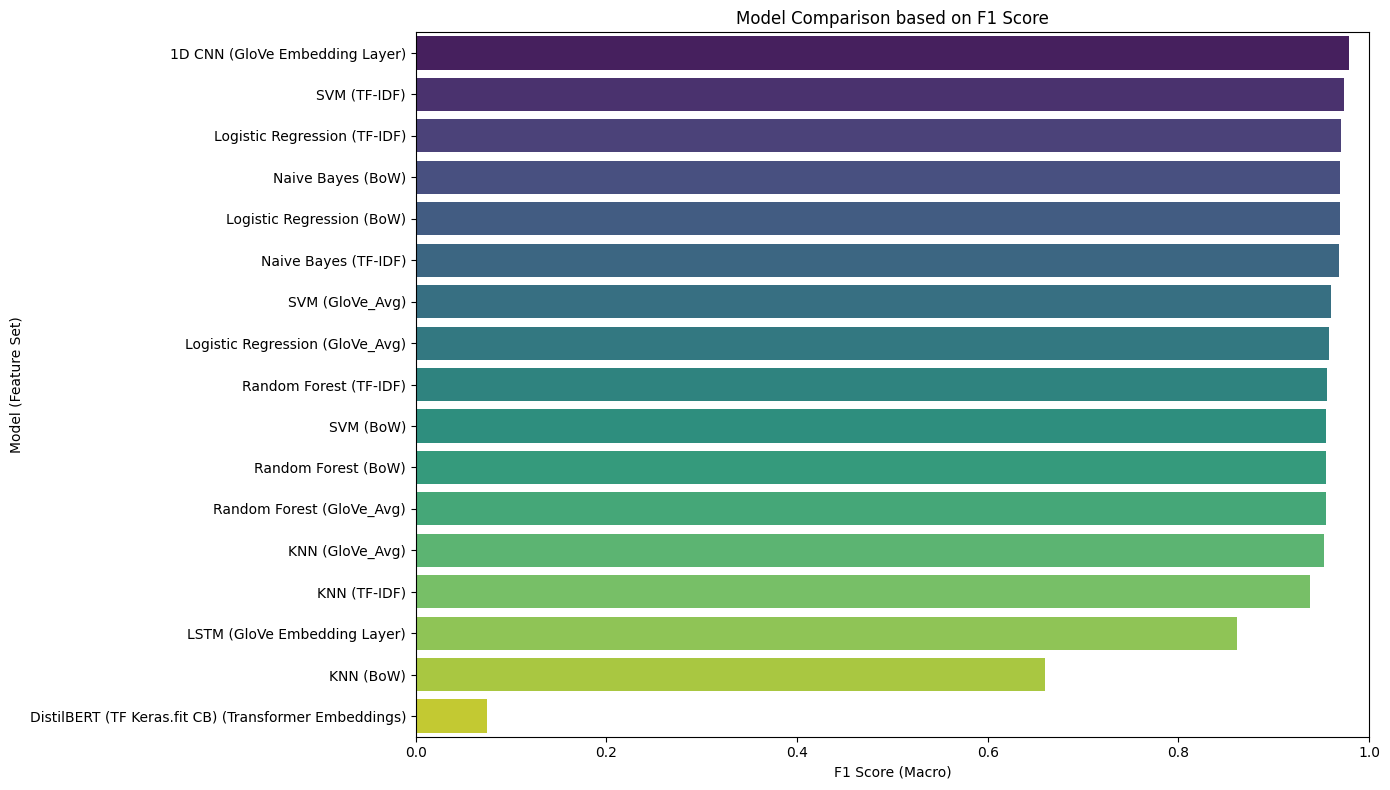

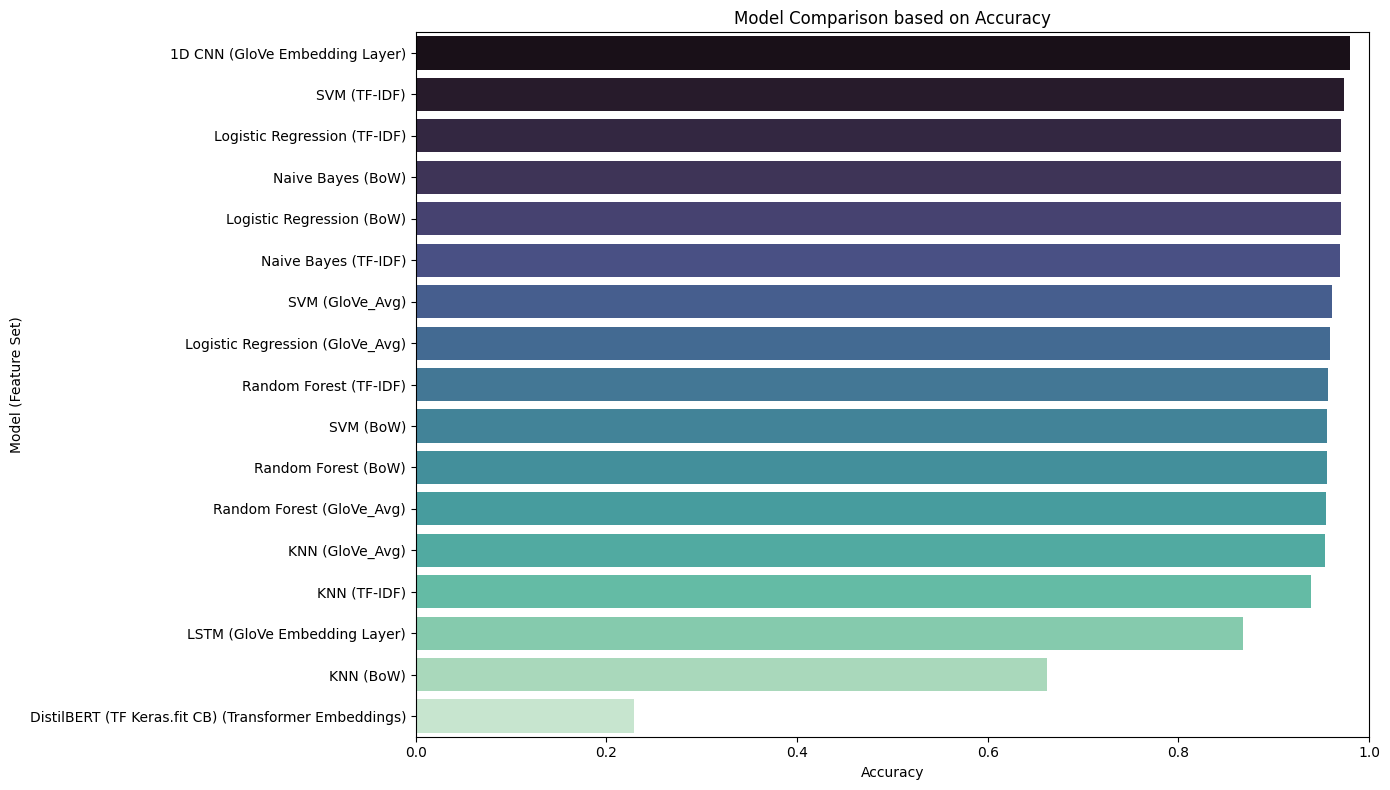

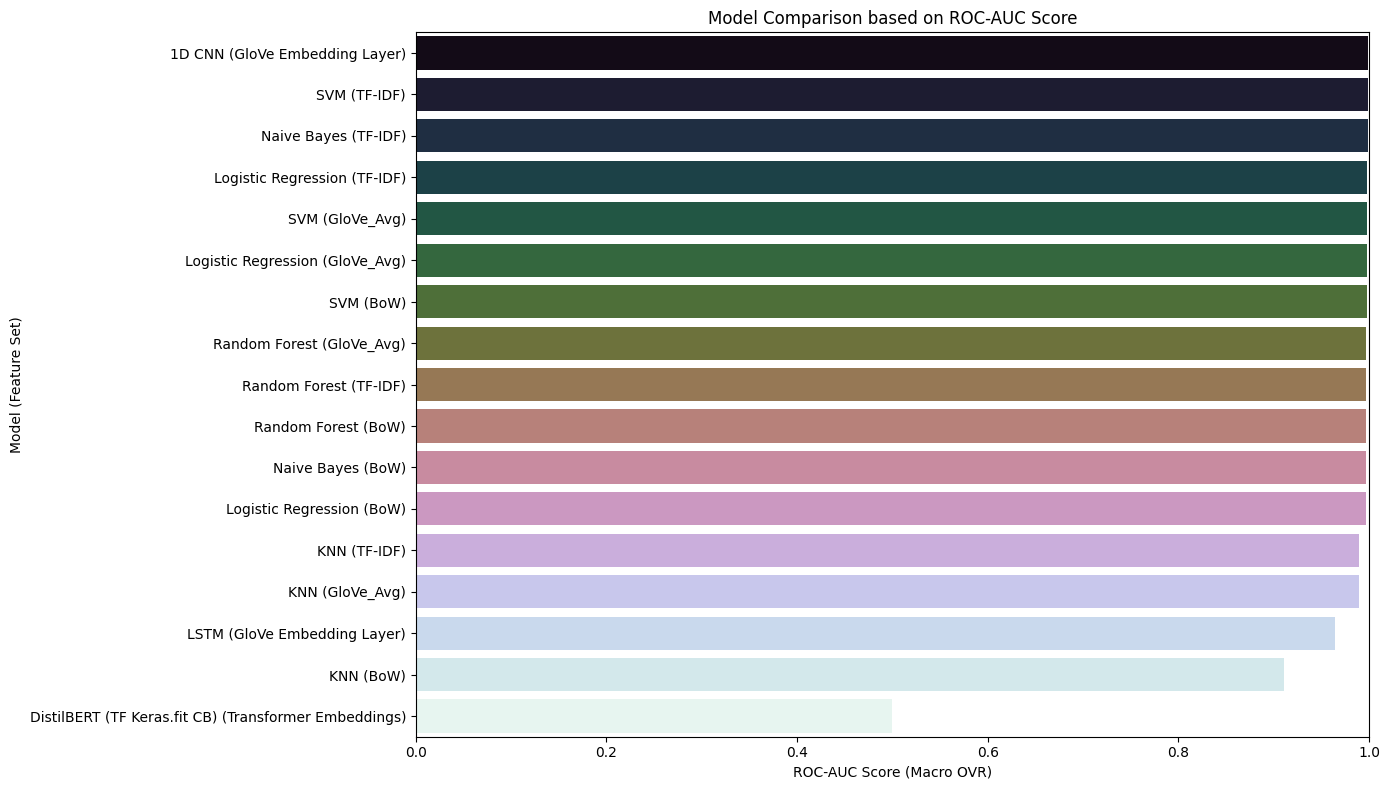


--- End of Text Classification Pipeline ---


In [26]:
# --- 8. Evaluation Metrics & Comparison ---
print("\n\n--- Part 8: Evaluation Metrics & Comparison ---")

# Combine all results
all_results_list = []
if 'classical_ml_results_df' in locals() and not classical_ml_results_df.empty:
    # For classical ML, we reported CV scores. Let's rename for consistency in final table.
    temp_classical_df = classical_ml_results_df.copy()
    temp_classical_df.rename(columns={
        "Accuracy (CV)": "Accuracy",
        "Precision (CV)": "Precision",
        "Recall (CV)": "Recall",
        "F1 Score (CV)": "F1 Score",
        "ROC-AUC (CV)": "ROC-AUC"
    }, inplace=True)
    all_results_list.append(temp_classical_df)

if 'dl_models_results_df' in locals() and not dl_models_results_df.empty:
    all_results_list.append(dl_models_results_df)

if 'transformer_results_df' in locals() and not transformer_results_df.empty:
    all_results_list.append(transformer_results_df)

if not all_results_list:
    print("No results available to display.")
else:
    final_results_df = pd.concat(all_results_list, ignore_index=True)
    final_results_df = final_results_df[["Model", "Feature Set", "Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]]

    print("\n--- Combined Model Performance ---")
    # Sort by F1 Score for better comparison
    final_results_df_sorted = final_results_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
    print(final_results_df_sorted.to_string())


    # --- Visualizations ---
    if not final_results_df_sorted.empty:
        plt.figure(figsize=(14, 8))
        # Create a combined Model_Feature label for better plotting
        final_results_df_sorted['Model_Feature'] = final_results_df_sorted['Model'] + " (" + final_results_df_sorted['Feature Set'] + ")"
        
        sns.barplot(x="F1 Score", y="Model_Feature", data=final_results_df_sorted, palette="viridis")
        plt.title('Model Comparison based on F1 Score')
        plt.xlabel('F1 Score (Macro)')
        plt.ylabel('Model (Feature Set)')
        plt.xlim(0, 1) # F1 score is between 0 and 1
        plt.tight_layout()
        plt.show()

        # Plotting other metrics like Accuracy
        plt.figure(figsize=(14, 8))
        sns.barplot(x="Accuracy", y="Model_Feature", data=final_results_df_sorted.sort_values(by="Accuracy", ascending=False), palette="mako")
        plt.title('Model Comparison based on Accuracy')
        plt.xlabel('Accuracy')
        plt.ylabel('Model (Feature Set)')
        plt.xlim(0, 1) # Accuracy is between 0 and 1
        plt.tight_layout()
        plt.show()
        
        # Plotting ROC-AUC
        plt.figure(figsize=(14, 8))
        sns.barplot(x="ROC-AUC", y="Model_Feature", data=final_results_df_sorted.sort_values(by="ROC-AUC", ascending=False), palette="cubehelix")
        plt.title('Model Comparison based on ROC-AUC Score')
        plt.xlabel('ROC-AUC Score (Macro OVR)')
        plt.ylabel('Model (Feature Set)')
        plt.xlim(0, 1) # ROC-AUC is between 0 and 1
        plt.tight_layout()
        plt.show()

    else:
        print("No data to visualize.")

print("\n--- End of Text Classification Pipeline ---")